In [1]:
import nrrd

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure

from scipy.spatial import ConvexHull

### carrega um exemplo .nrrd

In [2]:
filename = '2 CONTRASTE VENOSO.nrrd'

# Read the data back from file
readdata, header = nrrd.read(filename)
print(readdata.shape)

(512, 512, 352)


In [3]:
sample_volume = readdata

In [4]:
#visualização do plano axial
# for i in range(sample_volume.shape[2]):
#     print(i)
#     plt.imshow(sample_volume[:,:,i], cmap='gray')
#     plt.show()

### pego como exemplo um corte do plano coronal

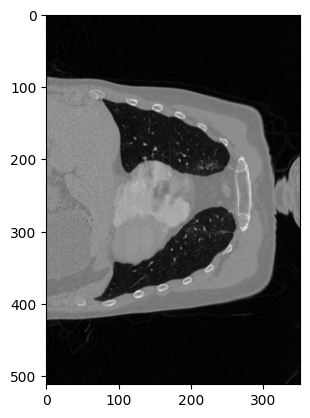

In [5]:
#coronal
# sample_image = sample_volume[:,351,:]
sample_image = sample_volume[:,200,:]
# sample_image = sample_volume[:,:,100]
plt.imshow(sample_image, cmap='gray')
plt.show()

### aplica a normalização entre 0 e 1

In [6]:
def clip_ct(volume, min, max):
    """
    Clips CT to predefined range and binarizes the values
    """
    minimum = np.min(volume)
    maximum = np.max(volume)
    
    if maximum > minimum:
        volume = (volume - minimum) / (maximum - minimum)
    else:
        volume = volume * 0.
        
    print(f'np.max(clipped): {maximum} np.min(clipped): {minimum}')
    
    return volume

def intensity_seg(ct_numpy, min=-500, max=1400):
    volume = clip_ct(ct_numpy, min, max)
    return measure.find_contours(volume, 0.35)

### procura por regiões com contorno e uma área de 2000 pixels

In [7]:
def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def contour_distance(contour):
    """
    Given a set of points that may describe a contour
     it calculates the distance between the first and the last point
     to infer if the set is closed.
    Args:
        contour: np array of x and y points

    Returns: euclidean distance of first and last point
    """
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return euclidean_dist(dx, dy)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False
    
def find_lungs(contours):
    """
    Chooses the contours that correspond to the lungs and the body
    FIrst we exclude non closed sets-contours
    Then we assume some min area and volume to exclude small contours
    Then the body is excluded as the highest volume closed set
    The remaining areas correspond to the lungs

    Args:
        contours: all the detected contours

    Returns: contours that correspond to the lung area

    """
    body_and_lung_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if set_is_closed(contour) and hull.volume > 2000:
            body_and_lung_contours.append(contour)

    print("body_and_lung_contours: ", len(body_and_lung_contours))
    
    return body_and_lung_contours

In [8]:
def show_contour(image, contours):#, name=None, save=False):
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

### pega a máscara dos poligonos (pulmões)

In [9]:
def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """

    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return lung_mask.T  # transpose it to be aligned with the image dims

### visualização de um exemplo com os pulmões marcados e as máscaras

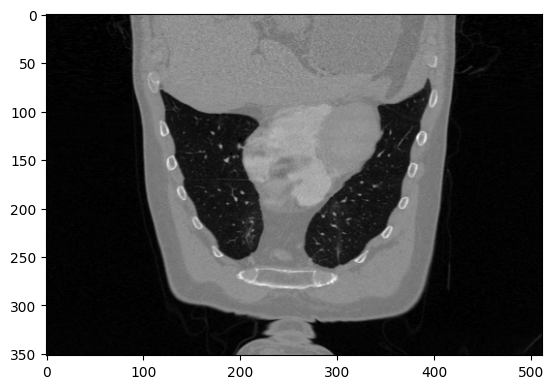

np.max(clipped): 936 np.min(clipped): -1024
contours:  44
body_and_lung_contours:  2
lungs:  2


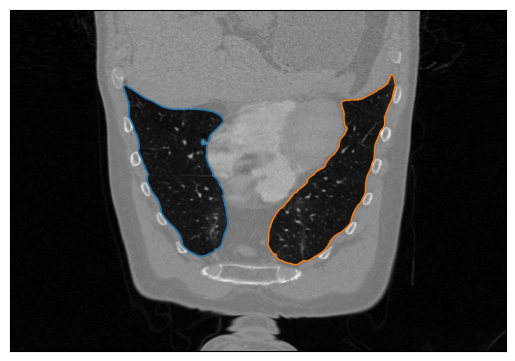

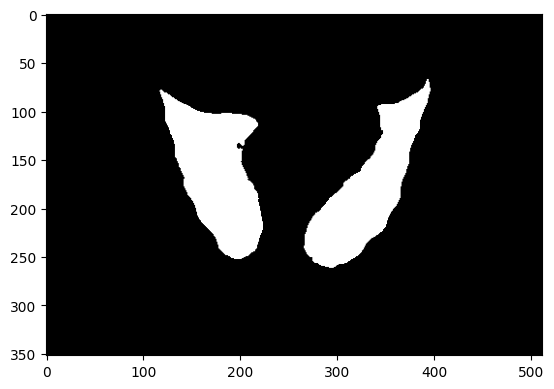

In [10]:
ct_numpy = sample_image
plt.imshow(sample_image.T, cmap='gray')
plt.show()

contours = intensity_seg(ct_numpy, min=-500, max=1400)
print("contours: ", len(contours))


lungs = find_lungs(contours)
print("lungs: ", len(lungs))

show_contour(ct_numpy, lungs)
lung_mask = create_mask_from_polygon(ct_numpy, lungs)

plt.imshow(lung_mask.T, cmap='gray')
plt.show()